# Deep and Cross Network
## Pytorch implementation based on the paper arxiv.org/abs/1708.05123

In [1]:
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
from torch.distributions import beta
import torch.onnx
import numpy as np
from sklearn.metrics import roc_auc_score
import os
import time
import sys
from torchvision.transforms import *
from tqdm import tqdm, tqdm_notebook, tnrange
import matplotlib.pyplot as plt

from torch_summary import summary
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

%matplotlib inline

In [2]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using %s"%device)

using cpu


In [3]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
    filename = cfg['filename']
    x_col_cat = cfg['features']['categorical']
    x_col_bin = cfg['features']['binary']
    x_col_num = cfg['features']['numerical']
    x_col_cyc = cfg['features']['cyclical']
    y_col = cfg['features']['label']
    w_col = cfg['features']['weight']

In [4]:
nrows=1e7
df = pd.read_csv(filename, nrows=nrows)
print("dataset size: %s"%str(df.shape))
print("ctr = %.5f"%((df[y_col]*df[w_col]).sum()*1./df[w_col].sum()))

dataset size: (602733, 30)
ctr = 0.00952


In [5]:
def merge_columns(arr):
    arr = arr.astype(str)
    vals = (arr[:,0].astype(object)+'_'+arr[:,1].astype(object))
    for i in range(2, arr.shape[1]):
        vals = (vals+'_'+arr[:,i].astype(object))
    return vals

In [6]:
cat_features = []
for f in x_col_cat:
    if(isinstance(f, str)==False):
        df[list(f.values())[0]] = df[list(f.values())[0]].fillna('unknown')
        df[list(f.keys())[0]] = merge_columns(df[list(f.values())[0]].values)
        cat_features.append(list(f.keys())[0])
    else:
        df[f] = df[f].fillna('unknown')
        cat_features.append(f)
print(cat_features)

['geo_state', 'geo_country', 'geo_city', 'zip_code', 'category_1', 'domain', 'app_bundle', 'publisher_id', 'device_type', 'device_os', 'device_os_version', 'device_browser', 'device_browser_version', 'carrier', 'language', 'exchange_id', 'banner_type', 'account_campaign', 'account_banner', 'account_advertiser', 'account_offer']


In [7]:
binary_features = []
for f in x_col_bin:
    uniques = df[f].unique()
    d = {uniques[0]:0, uniques[1]:1}
    df[f] = df[f].map(d)
    binary_features.append(f)
    print(f, d)
print(binary_features)

is_interstitial {'No': 0, 'Yes': 1}
is_mobile_web_optimized {'No': 0, 'Yes': 1}
is_app {'Yes': 0, 'No': 1}
['is_interstitial', 'is_mobile_web_optimized', 'is_app']


In [8]:
cyc_features = []
for f in x_col_cyc:
    nuniques = df[f].nunique()
    df[f+'_sin'] = np.sin(df[f]*(2.*np.pi/nuniques))
    df[f+'_cos'] = np.cos(df[f]*(2.*np.pi/nuniques))
    cyc_features.append(f+'_sin')
    cyc_features.append(f+'_cos')
    print(f, nuniques)
print(cyc_features)

user_day_of_week 7
user_hour 24
['user_day_of_week_sin', 'user_day_of_week_cos', 'user_hour_sin', 'user_hour_cos']


### Encoding

In [9]:
def binary_encode(s, modulo, required_bits=8):
    num = hash(s) % modulo
    return np.array(list(np.binary_repr(num).zfill(required_bits))).astype(np.int8)

def hashing_trick(s, modulo):
    num = hash(s) % modulo
    arr = np.zeros((modulo)).astype(np.int8)
    arr[num] = 1
    return arr

def get_sparse_index(s, modulo):
    return hash(s) % modulo

#### Combine columns

In [10]:
df = df[cat_features + binary_features + cyc_features + [y_col] + [w_col]]

Here we represent categorical features as sparse index. In production system this encoding can be done by maintaining a map of unique values per feature

In [11]:
cat_cols = {}
column_instance_dict = {}
modulos = []
for col in tqdm(cat_features):
    modulo = df[col].nunique()
    cat_cols[col] = modulo
    modulos.append(modulo)
    column_instance_dict[col] = dict(zip(df[col].unique(), range(len(df[col].unique()))))
    df[col] = df[col].map(column_instance_dict[col])
for c in cat_features:
    print(c, cat_cols[c])

100%|██████████| 21/21 [00:02<00:00,  7.44it/s]

geo_state 642
geo_country 13
geo_city 5412
zip_code 9629
category_1 58
domain 4990
app_bundle 3570
publisher_id 2614
device_type 6
device_os 11
device_os_version 140
device_browser 27
device_browser_version 893
carrier 664
language 78
exchange_id 7
banner_type 3
account_campaign 20
account_banner 60
account_advertiser 8
account_offer 11


In [12]:
embed_list = []
for c in cat_cols:
    if(cat_cols[c]<=10):
        embed_list.append([c, cat_cols[c], 3])
    elif(cat_cols[c]<=100):
        embed_list.append([c, cat_cols[c], 5])
    else:
        embed_list.append([c, cat_cols[c], 10])
embed_list

[['geo_state', 642, 10],
 ['geo_country', 13, 5],
 ['geo_city', 5412, 10],
 ['zip_code', 9629, 10],
 ['category_1', 58, 5],
 ['domain', 4990, 10],
 ['app_bundle', 3570, 10],
 ['publisher_id', 2614, 10],
 ['device_type', 6, 3],
 ['device_os', 11, 5],
 ['device_os_version', 140, 10],
 ['device_browser', 27, 5],
 ['device_browser_version', 893, 10],
 ['carrier', 664, 10],
 ['language', 78, 5],
 ['exchange_id', 7, 3],
 ['banner_type', 3, 3],
 ['account_campaign', 20, 5],
 ['account_banner', 60, 5],
 ['account_advertiser', 8, 3],
 ['account_offer', 11, 5]]

In [13]:
x_cols = [c for c in df.columns if (c != 'clicks') and (c != 'impressions')]
print("number of x columns: %d"%(len(x_cols)))

number of x columns: 28


In [14]:
x_sparse = df[x_cols[:len(cat_features)]].values
x_dense = df[x_cols[len(cat_features):]].values
x = np.concatenate([x_sparse, x_dense], axis=1)
y, w = np.array(df[y_col]), np.array(df[w_col])
print("x_dense: %s x_sparse: %s y: %s w: %s"%(x_dense.shape, x_sparse.shape, y.shape, w.shape))
del df

x_dense: (602733, 7) x_sparse: (602733, 21) y: (602733,) w: (602733,)


### Prepare data for pytorch and split

In [15]:
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
w = torch.FloatTensor(w).to(device)

In [16]:
n, m = x.shape
randvec = torch.randperm(n)
x_train, x_val = torch.split(x[randvec],(n*3)//5, 0)
y_train, y_val = torch.split(y[randvec],(n*3)//5, 0)
w_train, w_val = torch.split(w[randvec],(n*3)//5, 0)

n_val = x_val.shape[0]
randvec_val = torch.randperm(n_val)
x_val, x_test = torch.split(x_val[randvec_val],n_val//2, 0)
y_val, y_test = torch.split(y_val[randvec_val],n_val//2, 0)
w_val, w_test = torch.split(w_val[randvec_val],n_val//2, 0)

print("num obs train %d\nnum obs val %d\nnum obs test %d"%(x_train.shape[0], x_val.shape[0], x_test.shape[0]))

num obs train 361639
num obs val 120547
num obs test 120547


## Build Model

### Define Hyperparameters

In [17]:
sparse_col = torch.LongTensor(list(range(0, len(cat_features))))
dense_col = torch.LongTensor(list(range(len(cat_features), m)))
m_sparse = sparse_col.size()[0]
m_dense = dense_col.size()[0]
print("num of sparse cols: %d\nnum of dense cols: %d"%(m_sparse, m_dense))

num of sparse cols: 21
num of dense cols: 7


### Define Network layers

In [18]:
class Cross(nn.Module):
    def __init__(self, output_features, x0):
        super(Cross, self).__init__()
        self.output_features = output_features
        self.x0 = x0

        self.weight = nn.Parameter(torch.FloatTensor(output_features, 1).to(x0.device))
        self.bias = nn.Parameter(torch.FloatTensor(1, output_features).to(x0.device))

        self.weight.data.uniform_(-0.1, 0.1)
        self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        x_w = input.mm(self.weight).unsqueeze_(-1)
        x0T = self.x0.clone().unsqueeze_(-1).permute([0,2,1])
        f = torch.bmm(x_w, x0T).squeeze()
        output = f + self.bias + input
        return output

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias
        )


In [19]:
class DeepAndCrossNetwork(nn.Module):
    def __init__(self, features_metadata, dense_size, num_deep_layers, num_cross_layers, d_units, w_units, dropout=0.5):
        super().__init__()
        self.num_dls = num_deep_layers
        self.num_cls = num_cross_layers
        self.d_units = d_units
        self.w_units = w_units
        self.embedding_layers = nn.ModuleList([nn.Embedding(num_embeddings=int(feature[1]), embedding_dim=int(feature[2])) for feature in features_metadata])
        embedding_size = sum([int(feature[2]) for feature in features_metadata])
        self.cross_layer_size = dense_size + embedding_size
        
         #deep network layers
        self.fc1 = nn.Linear(self.cross_layer_size, d_units, bias=True)
        self.bn = nn.BatchNorm1d(d_units)
        self.dropout = nn.Dropout(p=dropout)
        
        self.dropouts = nn.ModuleList([nn.Dropout(p=dropout) for _ in range(self.num_dls)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(d_units) for _ in range(self.num_dls)])
        self.fc2s = nn.ModuleList([nn.Linear(d_units, d_units, bias=True) for _ in range(self.num_dls)])
        
        #cross network layers
        self.linear_with_bias = nn.Linear(self.cross_layer_size, self.cross_layer_size, bias=True)
        self.cross_layer_bn = nn.BatchNorm1d(self.cross_layer_size)
        
        #wide network layers
        self.wide = nn.Linear(self.cross_layer_size, w_units, bias=True)
        
        #combination layer
        self.combine = nn.Linear(d_units+w_units+self.cross_layer_size, 1, bias=True)
        
        #output
        self.output = nn.Sigmoid()

    def forward(self, x):
        m_sparse = len(self.embedding_layers)
        x_sparse = x[:,:m_sparse].long()
        x_dense = x[:,m_sparse:]
        embedding_tensor = torch.cat([self.embedding_layers[sparse_feature](x_sparse[:, sparse_feature]) for sparse_feature in range(m_sparse)], dim=1)
        x0 = torch.cat([embedding_tensor, x_dense], dim=1)
        x_dl = F.relu(self.dropout(self.bn(self.fc1(x0))))
        for i in range(self.num_dls):
            x_dl = self.dropouts[i](self.bns[i](self.fc2s[i](x_dl)))
        
        x_wl = self.wide(x0)
        
        x_cl = self.linear_with_bias(x0)
        for _ in range(self.num_cls):
            x_cl = Cross(self.cross_layer_size, x0)(x_cl)
        
        x_final = torch.cat([x_dl, x_wl, x_cl], dim=1)
        result = self.combine(x_final)
        y = self.output(result)
        return y

### Define Model parameters

In [42]:
np.random.seed(SEED)
torch.manual_seed(SEED)
model = DeepAndCrossNetwork(embed_list, m_dense, 5, 3, 100, 500).to(device)
summary([x_val.shape[1]], model, device)

----------------------------------------------------------------
Layer (type)          Output Shpae              Param #        
Embedding-1           [-1, 10]                  6420           
Embedding-2           [-1, 5]                   65             
Embedding-3           [-1, 10]                  54120          
Embedding-4           [-1, 10]                  96290          
Embedding-5           [-1, 5]                   290            
Embedding-6           [-1, 10]                  49900          
Embedding-7           [-1, 10]                  35700          
Embedding-8           [-1, 10]                  26140          
Embedding-9           [-1, 3]                   18             
Embedding-10          [-1, 5]                   55             
Embedding-11          [-1, 10]                  1400           
Embedding-12          [-1, 5]                   135            
Embedding-13          [-1, 10]                  8930           
Embedding-14          [-1, 10]         

In [43]:
criterion = nn.BCELoss(reduction='sum')
lr = .001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=1.2)
epochs = 10
batch_size = 2**14
num_batches = int(len(y_train)//batch_size)
MAX_BATCH_SIZE = 2**15
MIN_LR = 1e-5
print("Model parameters:")
print("criterion:\n%s"%str(criterion))
print("optimizer:\n%s"%str(optimizer))
print("epochs: %d"%epochs)
print("batch_size: %d"%batch_size)
print("num_batches: %d"%num_batches)
print("MAX_BATCH_SIZE: %d"%MAX_BATCH_SIZE)
print("max number of batches: %d"%(int(len(y_train)//MAX_BATCH_SIZE)))
print("MIN_LR: %f"%MIN_LR)

Model parameters:
criterion:
BCELoss()
optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
)
epochs: 10
batch_size: 16384
num_batches: 22
MAX_BATCH_SIZE: 32768
max number of batches: 11
MIN_LR: 0.000010


## Run the model

In [44]:
train_loss = 0
val_loss = 0
mean_val_loss, val_auc, val_cal = [], [], []
x_val_sparse = x_val[:,sparse_col]
x_val_dense = x_val[:,dense_col]
print("start training")
l = 27
pattern = "[%%-%ds]"%l
for t in range(epochs):
    model.train()
    if((t+1)%20==0 and batch_size<=MAX_BATCH_SIZE):
        batch_size *= 2**2
        num_batches = int(len(y_train)//batch_size)
    if((t+1)%10==0 and lr>=MIN_LR):
        lr *= 0.8
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    start_time = time.time()
    epochrandvec=torch.randperm(len(y_train))
    x_train = x_train[epochrandvec,:]
    y_train = y_train[epochrandvec]
    w_train = w_train[epochrandvec]
    for i in range(num_batches):
        
        indvec = torch.LongTensor(list(range((i)*batch_size, (i)*batch_size+batch_size)))
        x_batch = x_train[indvec]
        y_batch = y_train[indvec]
        criterion.weight = w_train[indvec]
        
        x_sparse = x_batch[:,sparse_col]
        x_dense = x_batch[:,dense_col]

        #initialize
        optimizer.zero_grad()
        
        # forward + backward + optimize
        trainOutputs = model(x_batch)
        loss = criterion(trainOutputs.squeeze(), y_batch)
        train_loss = loss.item()
        
        #Update Network
        loss.backward()
        optimizer.step()

        #evaluation metrics
        with torch.no_grad():
            model.eval()
            valOutputs = model(x_val)
            criterion.weight = w_val
            validation = criterion(valOutputs.squeeze(), y_val)
            val_loss = validation.item()
            mean_val_loss.append(val_loss/x_val.shape[0])
            val_auc.append(roc_auc_score(y_val.cpu().data.numpy(), valOutputs.cpu().data.numpy(), sample_weight=w_val))
            val_cal.append((valOutputs.squeeze().mul(w_val).sum() / y_val.mul(w_val).sum()).item())
        torch.cuda.empty_cache()
        sys.stdout.write("\r" + pattern%('='*(int(i*l/num_batches))+'>') + " " +\
                         "e: %3d/%3d, b: %3d/%3d, lr: %.5f, loss=%.3f, val_loss=%.3f, auc=%.3f, val_cal=%.3f"%
                          (t+1, epochs, i+1, num_batches, lr,
                          train_loss/(batch_size*(i+1+t*num_batches)), mean_val_loss[-1], 
                          val_auc[-1], val_cal[-1]))
        sys.stdout.flush()
    end_time = time.time()
    elapsed = end_time - start_time
    sys.stdout.write("\r")
    print(pattern%('='*(l-1)+'>') + " " +\
          "e: %3d/%3d, b: %3d/%3d, lr: %.5f, loss=%.3f, val_loss=%.3f, auc=%.3f, val_cal=%.3f, %.2fs"%
          (t+1, epochs, i+1, num_batches, lr,
          train_loss/(batch_size*(i+1+t*num_batches)), mean_val_loss[-1], 
          val_auc[-1], val_cal[-1], elapsed))
    
print('Finished Training')

start training
[==========================>] e:   1/ 10, b:  22/ 22, lr: 0.00100, loss=0.003, val_loss=0.074, auc=0.778, val_cal=0.294, 60.90s
[==========================>] e:   2/ 10, b:  22/ 22, lr: 0.00100, loss=0.001, val_loss=0.065, auc=0.820, val_cal=1.171, 62.37s
[==========================>] e:   3/ 10, b:  22/ 22, lr: 0.00100, loss=0.001, val_loss=0.061, auc=0.820, val_cal=0.975, 62.52s
[==========================>] e:   4/ 10, b:  22/ 22, lr: 0.00100, loss=0.001, val_loss=0.060, auc=0.823, val_cal=1.046, 63.10s
[==========================>] e:   5/ 10, b:  22/ 22, lr: 0.00100, loss=0.001, val_loss=0.060, auc=0.825, val_cal=1.047, 63.53s
[==========================>] e:   6/ 10, b:  22/ 22, lr: 0.00100, loss=0.000, val_loss=0.059, auc=0.831, val_cal=1.089, 61.66s
[==========================>] e:   7/ 10, b:  22/ 22, lr: 0.00100, loss=0.000, val_loss=0.059, auc=0.833, val_cal=1.056, 60.54s
[==========================>] e:   8/ 10, b:  22/ 22, lr: 0.00100, loss=0.000, val_loss=0

## Calculate AUC and calibration metrics
### These predictions are done in evaluation mode. Setting the SEED and calling $eval()$ make the evaluation reproducible

In [45]:
torch.cuda.empty_cache()
for data in [[x_val, y_val, w_val, 'val'], [x_test, y_test, w_test, 'test']]:
    with torch.no_grad():
        model.eval()
        torch.manual_seed(SEED)
        probs = model(data[0].squeeze())
        sample_weight = data[2].cpu().data.numpy()
        torch.cuda.empty_cache()
        print(data[3]+':')
        print("number of observations = %d"%(len(data[1].cpu().data.numpy())))
        print("\tAUC = %.4f"%(roc_auc_score(data[1].cpu().data.numpy(), probs.cpu().data.numpy(), sample_weight=sample_weight)))
        print("\tCalibration = %.4f"%(probs.flatten().dot(data[2])/data[1].dot(data[2]).item()))
        print("\tctrpm = %.2f"%(1000*data[1].dot(data[2])/data[1].shape[0]))

val:
number of observations = 120547
	AUC = 0.8454
	Calibration = 0.9737
	ctrpm = 12.19
test:
number of observations = 120547
	AUC = 0.8459
	Calibration = 0.9564
	ctrpm = 12.22


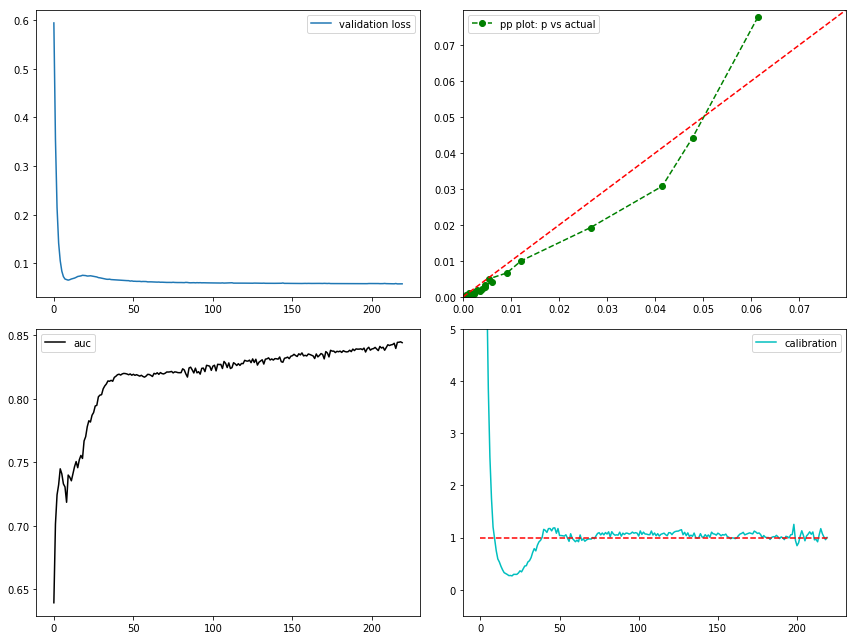

In [46]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.plot(mean_val_loss, label='validation loss')
plt.legend()
plt.subplot(2,2,2)
with torch.no_grad():
    torch.manual_seed(SEED)
    probs = model(x_test.squeeze())
v = torch.cat([probs.cpu().reshape((probs.shape[0],1)),y_test.cpu().reshape((y_test.shape[0],1))], dim=1).data.numpy()
v = v[np.argsort(v[:, 0])[::-1]]
means = np.array_split(v, 20)
means = np.array([[v[:, 0].mean(), v[:, 1].mean()] for v in means])
max_v = np.max(means)+0.002
plt.plot(means[:, 1], means[:,0], 'o--g', label='pp plot: p vs actual');
plt.plot([0,max_v],[0,max_v],'r--')
plt.xlim([0,max_v])
plt.ylim([0,max_v])
plt.legend()
plt.subplot(2,2,3)
plt.plot(val_auc, 'k-', label='auc')
plt.legend()
plt.subplot(2,2,4)
plt.plot(val_cal, 'c-', label='calibration')
plt.plot([0,len(val_cal)],[1,1], 'r--')
plt.ylim([-0.5, 5])
plt.legend();
plt.tight_layout();

## Save model and load it back for inference

In [47]:
PATH = 'model.pth'
torch.save(model.state_dict(), PATH)

In [50]:
reload_model = DeepAndCrossNetwork(embed_list, m_dense, 5, 1, 100, 500).to(device)
reload_model.load_state_dict(torch.load(PATH))
reload_model.eval()

DeepAndCrossNetwork(
  (embedding_layers): ModuleList(
    (0): Embedding(642, 10)
    (1): Embedding(13, 5)
    (2): Embedding(5412, 10)
    (3): Embedding(9629, 10)
    (4): Embedding(58, 5)
    (5): Embedding(4990, 10)
    (6): Embedding(3570, 10)
    (7): Embedding(2614, 10)
    (8): Embedding(6, 3)
    (9): Embedding(11, 5)
    (10): Embedding(140, 10)
    (11): Embedding(27, 5)
    (12): Embedding(893, 10)
    (13): Embedding(664, 10)
    (14): Embedding(78, 5)
    (15): Embedding(7, 3)
    (16): Embedding(3, 3)
    (17): Embedding(20, 5)
    (18): Embedding(60, 5)
    (19): Embedding(8, 3)
    (20): Embedding(11, 5)
  )
  (fc1): Linear(in_features=149, out_features=100, bias=True)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5)
  (dropouts): ModuleList(
    (0): Dropout(p=0.5)
    (1): Dropout(p=0.5)
    (2): Dropout(p=0.5)
    (3): Dropout(p=0.5)
    (4): Dropout(p=0.5)
  )
  (bns): ModuleList(
    (0): BatchN

In [51]:
torch.cuda.empty_cache()
for data in [[x_val, y_val, w_val, 'val'], [x_test, y_test, w_test, 'test']]:
    with torch.no_grad():
        reload_model.eval()
        torch.manual_seed(SEED)
        probs = model(data[0].squeeze())
        sample_weight = data[2].cpu().data.numpy()
        torch.cuda.empty_cache()
        print(data[3]+':')
        print("number of observations = %d"%(len(data[1].cpu().data.numpy())))
        print("\tAUC = %.4f"%(roc_auc_score(data[1].cpu().data.numpy(), probs.cpu().data.numpy(), sample_weight=sample_weight)))
        print("\tCalibration = %.4f"%(probs.flatten().dot(data[2])/data[1].dot(data[2]).item()))
        print("\tctrpm = %.2f"%(1000*data[1].dot(data[2])/data[1].shape[0]))

val:
number of observations = 120547
	AUC = 0.8454
	Calibration = 0.9737
	ctrpm = 12.19
test:
number of observations = 120547
	AUC = 0.8459
	Calibration = 0.9564
	ctrpm = 12.22
